In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1189
┌ Info: Precompiling Rsvg [c4c386cf-5103-5370-be45-f3a111cca3b8]
└ @ Base loading.jl:1189
┌ Info: Recompiling stale cache file /home/pbarletta/.julia/compiled/v1.0/LaTeXStrings/H4HGh.ji for LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /home/pbarletta/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1187
┌ Warning: Module VersionParsing with build ID 266908957247274 is missing from the cache.
│ This may mean VersionParsing [81def892-9a0e-5fdd-b105-ffc91e053289] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:944
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
│   exception = Required dependency VersionParsing [81def892-9a0e-5fdd-b105-ffc91e053289

Plots.PyPlotBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "2ifb"
# Leo modos
modes_2ifb, evals_2ifb = JUMD.readPtrajModes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_2ifb))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_2ifb = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_2ifb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_2ifb = (ndd_out_2ifb .- vol_avg_2ifb) .* evals_2ifb
vgv_2ifb = vgv_2ifb ./ norm(vgv_2ifb);

## Volumen de la trayectoria

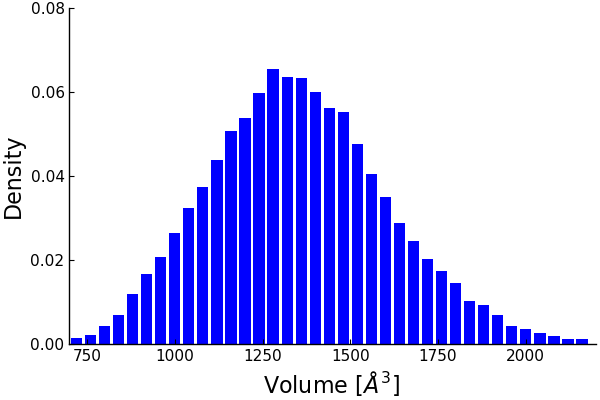

In [4]:
st = 40
bin_vol = collect(700:st:2200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_2ifb, Whis_vol_2ifb = JUMD.weightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_2ifb, Whis_vol_2ifb,
    xlims = (700, 2200), ylims = (0, .08),
    xticks = 500:250:2000,
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    grid = false, legend = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = L"Volume $[\AA^3]$ ")

In [4]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "1", string("1_vol_", pdb, ".svg")))

In [5]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1352.5429568999998
  254.2512729885925

## Energía

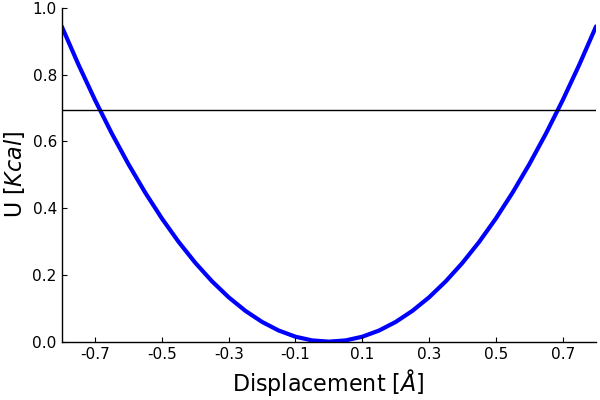

In [6]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_2ifb = Array{Float64,1}(undef, npasos)
[ E_2ifb[i] = JUMD.energiaGdte(evals_2ifb, vgv_2ifb, pasos[i]) for i in 1:npasos]

plt_u = plot(pasos, E_2ifb,
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8), ylims = (0, 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = L"U $[Kcal]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#0000FF", linewidth = 3,
    legend = false, grid = false)
hline!([RT], linecolor = Colors.colorant"black")

In [7]:
savefig(plt_u, joinpath(rtdos, "papel", "7", string("7_U_", pdb, ".svg")))

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [5]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_2ifb = Array{Float64, 1}(undef, nframes)
prj_2_2ifb = Array{Float64, 1}(undef, nframes)
prj_3_2ifb = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_2ifb[i] = dot(norm_dif[:, i], modes_2ifb[:, 1])
    prj_2_2ifb[i] = dot(norm_dif[:, i], modes_2ifb[:, 2])
    prj_3_2ifb[i] = dot(norm_dif[:, i], modes_2ifb[:, 3])
end

# Smooth
smooth_prj_1_2ifb = [ mean(prj_1_2ifb[i:i+9]) for i = 1:10:length(prj_1_2ifb)-9 ]
smooth_prj_2_2ifb = [ mean(prj_2_2ifb[i:i+9]) for i = 1:10:length(prj_2_2ifb)-9 ]
smooth_prj_3_2ifb = [ mean(prj_3_2ifb[i:i+9]) for i = 1:10:length(prj_3_2ifb)-9 ];

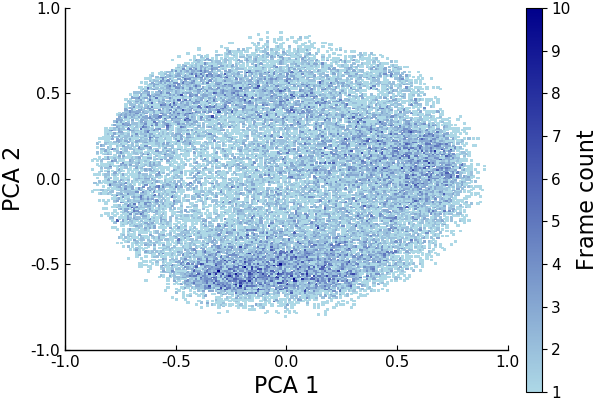

In [6]:
plt_2his = histogram2d(smooth_prj_1_2ifb, smooth_prj_2_2ifb, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    nbins = 200, seriescolor = :blues, grid = false)

In [20]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("2_PCAHis_", pdb, ".svg")))

In [7]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

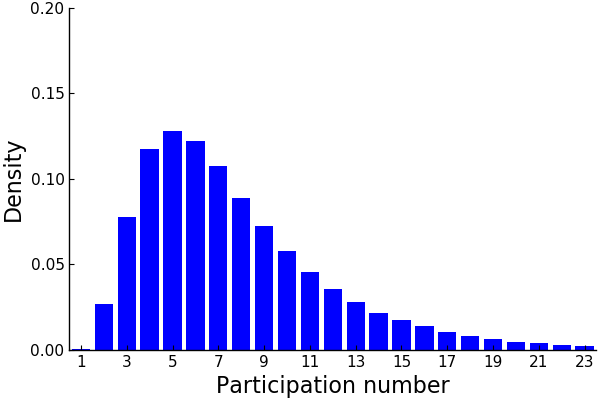

In [10]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.weightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number",
    legend = false, grid = false)

In [15]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

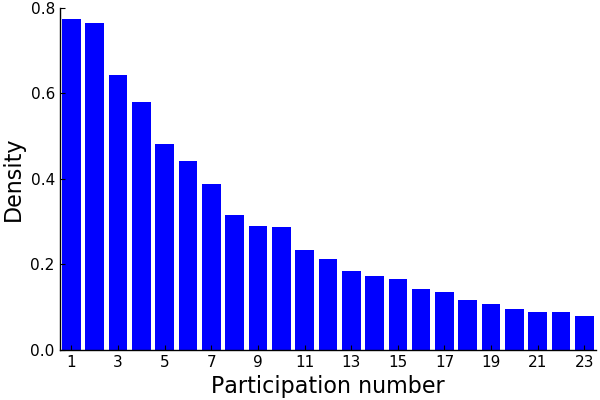

In [13]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.weightedHist(flat_marcos_modos,
    bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.2:.8,    
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number",
    legend = false, grid = false)

In [14]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))